## TDA-пайплайн: от трека к жанровой топологии

Этот ноутбук строит полный цикл:

1. Баровые MIR-фичи (`mir_bar_embeddings`) для каждого трека.
2. Persistent homology (H0/H1) по барам трека, Betti-кривые и фиксированный вектор признаков.
3. Агрегация по жанру: UMAP + HDBSCAN по топо-векторам треков, усреднённые Betti-кривые жанра, карточки отдельных треков.

In [1]:
import os
import sys
import warnings
from pathlib import Path
from typing import Dict, List

# Определение корня проекта для работы напрямую из ноутбука (VS Code, JupyterLab)
# Метод 1: Через IPython (работает в Jupyter/JupyterLab)
try:
    from IPython import get_ipython
    ipython = get_ipython()
    if ipython is not None:
        # Получаем путь к ноутбуку через IPython
        notebook_name = ipython.user_ns.get('__vsc_ipynb_file__') or ipython.user_ns.get('__file__')
        if notebook_name:
            notebook_path = Path(notebook_name).resolve()
            if 'notebooks' in str(notebook_path):
                project_root = notebook_path.parent.parent
            else:
                project_root = notebook_path.parent
        else:
            # Fallback: используем рабочую директорию
            cwd = Path.cwd().resolve()
            # Проверяем, находимся ли мы в notebooks/
            if (cwd / 'notebooks').exists() and (cwd / 'src').exists():
                project_root = cwd
            elif 'notebooks' in str(cwd):
                project_root = cwd.parent
            else:
                project_root = cwd
    else:
        raise AttributeError("Not in IPython")
except:
    # Метод 2: Через текущую рабочую директорию
    cwd = Path.cwd().resolve()
    # Проверяем структуру проекта
    if (cwd / 'notebooks').exists() and (cwd / 'src').exists():
        project_root = cwd
    elif 'notebooks' in str(cwd):
        project_root = cwd.parent
    else:
        # Пробуем найти корень проекта, поднимаясь вверх
        current = cwd
        while current != current.parent:
            if (current / 'notebooks').exists() and (current / 'src').exists():
                project_root = current
                break
            current = current.parent
        else:
            project_root = cwd

# Добавляем корневую директорию проекта и src/ в путь
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / 'src'))

# Проверка и вывод информации
print(f"✓ Корень проекта: {project_root}")
print(f"✓ Путь к src: {project_root / 'src'}")
print(f"✓ Текущая рабочая директория: {Path.cwd()}")

# Дополнительная проверка структуры проекта
if (project_root / 'notebooks').exists() and (project_root / 'src').exists():
    print(f"✓ Структура проекта найдена корректно")
else:
    print(f"⚠ ВНИМАНИЕ: Структура проекта не найдена!")
    print(f"  Проверьте, что папки 'notebooks' и 'src' существуют в {project_root}")

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import umap
import hdbscan
from ripser import ripser
from persim import plot_diagrams

from src.mir_bar_features import mir_bar_embeddings

plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 120
np.set_printoptions(precision=4, suppress=True)

warnings.filterwarnings(
    "ignore",
    message=".*n_jobs value 1 overridden to 1 by setting random_state.*",
    module="umap"
)
warnings.filterwarnings(
    "ignore",
    message="The input point cloud has more columns than rows; did you mean to transpose?",
    module="ripser"
)
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=".*force_all_finite.*",
    module="sklearn"
)


✓ Корень проекта: /Users/mverzhbitskiy/Documents/GitHub/3rdCourseWork
✓ Путь к src: /Users/mverzhbitskiy/Documents/GitHub/3rdCourseWork/src
✓ Текущая рабочая директория: /Users/mverzhbitskiy/Documents/GitHub/3rdCourseWork/notebooks
✓ Структура проекта найдена корректно


/Users/mverzhbitskiy/Documents/GitHub/3rdCourseWork/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Параметры и пути
# Используем project_root для надежности работы из любой директории
base_genre_dir = project_root / "data/1000songstry1"
file_extensions = ("*.wav", "*.mp3")

bar_kwargs = dict(
    beats_per_bar=4,
    use_auto_tempo=True,
    bpm=None,
)

betti_num_points = 200
betti_eps_max = None  # если None — берём max death per диаграмма

umap_params = dict(n_neighbors=15, min_dist=0.2, random_state=42)
hdbscan_params = dict(min_cluster_size=4, min_samples=2)

print(f"Жанровая директория: {base_genre_dir.resolve()}\nBetti points: {betti_num_points}")


Жанровая директория: /Users/mverzhbitskiy/Documents/GitHub/3rdCourseWork/data/1000songstry1
Betti points: 200


In [3]:
def list_audio_files(genre_dir: Path) -> List[Path]:
    files: List[Path] = []
    for ext in file_extensions:
        files.extend(sorted(genre_dir.glob(ext)))
    return files


def betti_curve(diagram: np.ndarray,
                num_points: int = 200,
                eps_max: float | None = None) -> np.ndarray:
    """Строит Betti-кривую (сколько живых классов при каждом epsilon)."""
    if diagram.size == 0:
        return np.zeros(num_points)

    births = diagram[:, 0]
    deaths = diagram[:, 1]
    finite_mask = np.isfinite(deaths)
    finite_deaths = deaths[finite_mask]
    eps_max = eps_max or (finite_deaths.max() if finite_deaths.size else births.max())
    eps_max = float(max(eps_max, 1e-6))

    eps_grid = np.linspace(0, eps_max, num_points)
    curve = np.array([
        np.sum((births <= eps) & (deaths > eps))
        for eps in eps_grid
    ], dtype=float)
    return curve


def diagrams_to_vector(diagrams: List[np.ndarray],
                       num_points: int = 200) -> Dict[str, np.ndarray]:
    h0 = diagrams[0] if len(diagrams) > 0 else np.empty((0, 2))
    h1 = diagrams[1] if len(diagrams) > 1 else np.empty((0, 2))
    bc0 = betti_curve(h0, num_points=num_points, eps_max=betti_eps_max)
    bc1 = betti_curve(h1, num_points=num_points, eps_max=betti_eps_max)
    topo_vec = np.concatenate([bc0, bc1])
    return {
        "betti_h0": bc0,
        "betti_h1": bc1,
        "vector": topo_vec,
    }



In [4]:
def compute_track_topology(file_path: Path,
                           *,
                           plot: bool = True,
                           betti_points: int = betti_num_points) -> Dict[str, np.ndarray]:
    bars = mir_bar_embeddings(str(file_path), **bar_kwargs)
    if bars.size == 0:
        raise ValueError(f"No bar embeddings for {file_path}")

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(bars.astype(np.float32))

    reducer = umap.UMAP(n_components=2, **umap_params)
    umap_2d = reducer.fit_transform(X_scaled)

    ph = ripser(X_scaled, maxdim=1)
    diagrams = ph["dgms"]
    topo_data = diagrams_to_vector(diagrams, num_points=betti_points)

    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # UMAP scatter
        idx = np.arange(umap_2d.shape[0])
        sc = axes[0].scatter(
            umap_2d[:, 0], umap_2d[:, 1], c=idx,
            cmap="viridis", s=20
        )
        axes[0].set_title("UMAP по барам трека")
        axes[0].set_xlabel("UMAP 1")
        axes[0].set_ylabel("UMAP 2")
        plt.colorbar(sc, ax=axes[0], label="Индекс такта")

        # Persistence diagrams
        plot_diagrams(diagrams, ax=axes[1], show=False)
        axes[1].set_title("Persistence diagrams (H0/H1)")

        # Betti curves
        eps_grid = np.linspace(0, 1, betti_points)
        axes[2].plot(eps_grid, topo_data["betti_h0"], label="Betti₀")
        axes[2].plot(eps_grid, topo_data["betti_h1"], label="Betti₁")
        axes[2].set_title("Betti-кривые")
        axes[2].set_xlabel("ε")
        axes[2].set_ylabel("# классов")
        axes[2].legend()
        axes[2].grid(alpha=0.3)

        fig.suptitle(f"{file_path.name}: {bars.shape[0]} тактов", fontsize=14)
        plt.tight_layout()
        plt.show()

    return {
        "bars": bars,
        "X_scaled": X_scaled,
        "umap_2d": umap_2d,
        "diagrams": diagrams,
        "betti_h0": topo_data["betti_h0"],
        "betti_h1": topo_data["betti_h1"],
        "topo_vector": topo_data["vector"],
    }



In [5]:
def process_genre(genre_name: str,
                  limit_tracks: int | None = None) -> Dict:
    genre_dir = base_genre_dir / genre_name
    if not genre_dir.exists():
        raise FileNotFoundError(f"Нет жанра {genre_name} в {base_genre_dir}")

    files = list_audio_files(genre_dir)
    if limit_tracks:
        files = files[:limit_tracks]
    if not files:
        raise ValueError(f"Нет файлов в {genre_dir}")

    track_data = []
    failed = []
    for fp in files:
        try:
            td = compute_track_topology(fp, plot=False)
            td["file"] = fp
            track_data.append(td)
        except Exception as exc:
            print(f"Ошибка {fp.name}: {exc}")
            failed.append(fp)

    if not track_data:
        raise RuntimeError("Не удалось обработать ни одного трека")

    topo_vectors = np.vstack([td["topo_vector"] for td in track_data])
    reducer = umap.UMAP(n_components=2, **umap_params)
    track_umap = reducer.fit_transform(topo_vectors)
    clusterer = hdbscan.HDBSCAN(**hdbscan_params)
    labels = clusterer.fit_predict(topo_vectors)

    betti_h0 = np.vstack([td["betti_h0"] for td in track_data])
    betti_h1 = np.vstack([td["betti_h1"] for td in track_data])

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # UMAP по трекам
    scatter = axes[0].scatter(
        track_umap[:, 0], track_umap[:, 1],
        c=labels, cmap="tab10", s=60, edgecolor="k", linewidth=0.4
    )
    axes[0].set_title(f"UMAP треков жанра {genre_name}")
    axes[0].set_xlabel("UMAP 1")
    axes[0].set_ylabel("UMAP 2")
    plt.colorbar(scatter, ax=axes[0], label="HDBSCAN cluster")

    # Средние Betti кривые
    eps = np.linspace(0, 1, betti_num_points)
    axes[1].plot(eps, betti_h0.mean(axis=0), label="Betti₀ (mean)", color="C0")
    axes[1].fill_between(eps,
                         np.maximum(0, betti_h0.mean(axis=0) - betti_h0.std(axis=0)),
                         betti_h0.mean(axis=0) + betti_h0.std(axis=0),
                         color="C0", alpha=0.2)
    axes[1].plot(eps, betti_h1.mean(axis=0), label="Betti₁ (mean)", color="C1")
    axes[1].fill_between(eps,
                         np.maximum(0, betti_h1.mean(axis=0) - betti_h1.std(axis=0)),
                         betti_h1.mean(axis=0) + betti_h1.std(axis=0),
                         color="C1", alpha=0.2)
    axes[1].set_title("Жанровые Betti-кривые (mean±std)")
    axes[1].set_xlabel("ε")
    axes[1].set_ylabel("# классов")
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    fig.suptitle(f"Жанр {genre_name}: {len(track_data)} треков, clusters={np.unique(labels).size}", fontsize=14)
    plt.tight_layout()
    plt.show()

    return {
        "genre": genre_name,
        "track_data": track_data,
        "topo_vectors": topo_vectors,
        "track_umap": track_umap,
        "cluster_labels": labels,
        "failed": failed,
    }



### Анализ одного трека: PH + Betti + UMAP


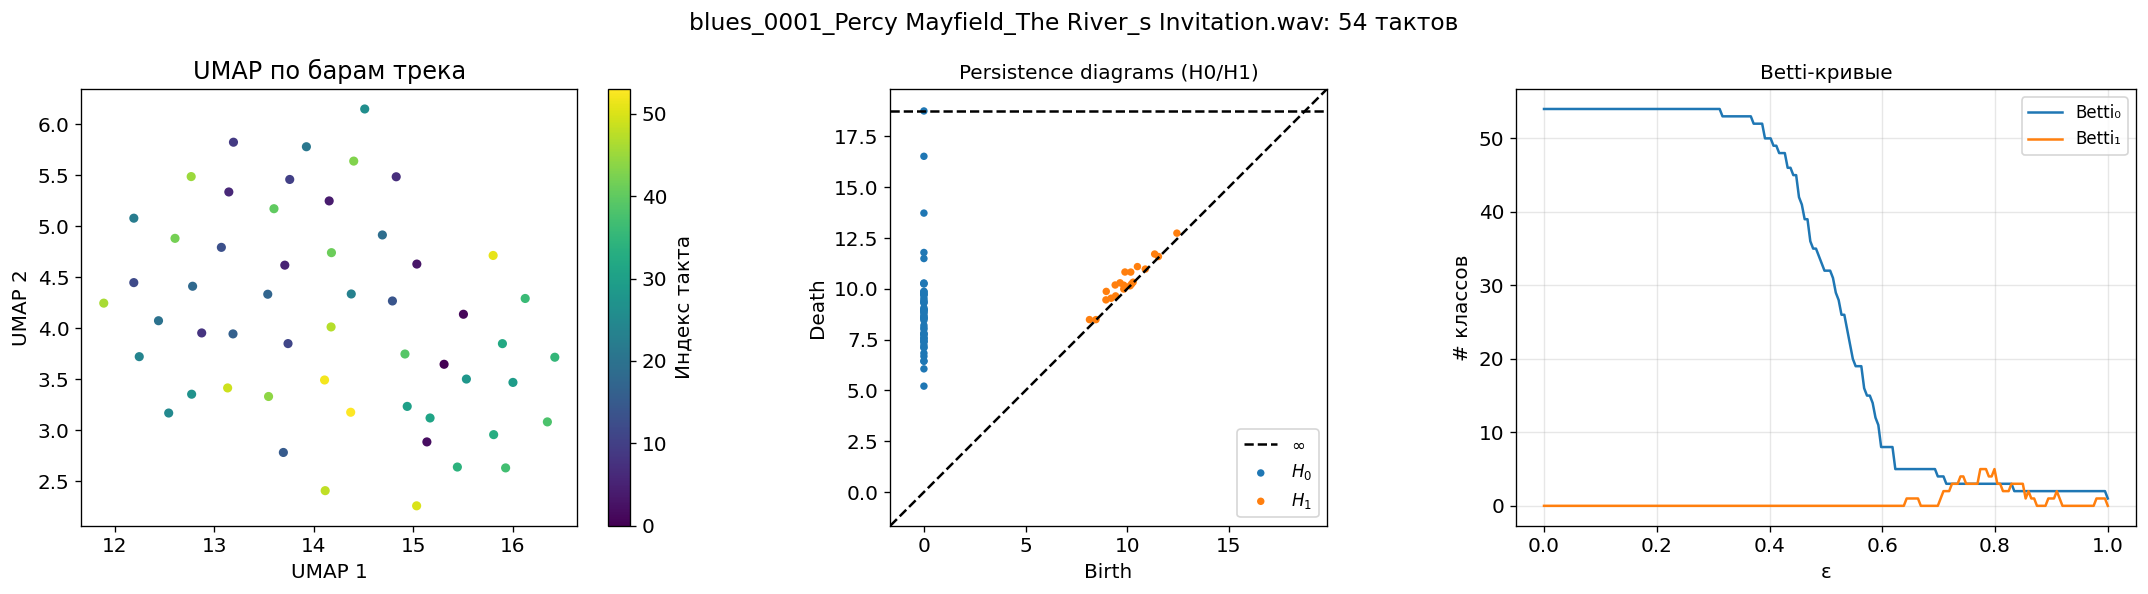

In [7]:
single_track_path = base_genre_dir / "blues" / "blues_0001_Percy Mayfield_The River_s Invitation.wav"
track_result = compute_track_topology(single_track_path, plot=True)


### Топологический профиль всего жанра


Ошибка blues_0050_Lost in Blues, Sime Tunes, Blues Whiskey_Got No More Time.wav: boolean index did not match indexed array along axis 1; size of axis is 19026 but size of corresponding boolean axis is 19025


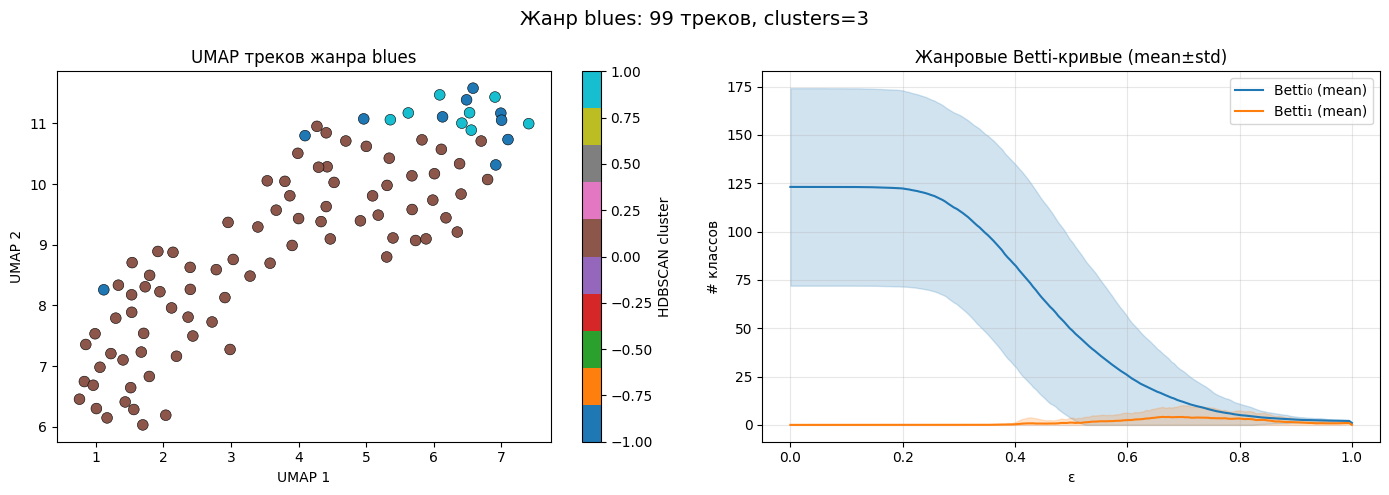

Обработано треков: 99
Не обработаны: ['blues_0050_Lost in Blues, Sime Tunes, Blues Whiskey_Got No More Time.wav']


In [8]:
genre_name = "blues"
genre_result = process_genre(genre_name, limit_tracks=None)
print(f"Обработано треков: {len(genre_result['track_data'])}")
if genre_result['failed']:
    print("Не обработаны:", [fp.name for fp in genre_result['failed']])


### Прогон по всем жанрам


In [9]:
available_genres = [p.name for p in sorted(base_genre_dir.iterdir()) if p.is_dir()]
print("Доступные жанры:", ", ".join(available_genres))

genre_reports: Dict[str, Dict] = {}


Доступные жанры: blues, classical, country, electronic, hip-hop, jazz, metal, pop, reggae, rock


#### Blues


Ошибка blues_0050_Lost in Blues, Sime Tunes, Blues Whiskey_Got No More Time.wav: boolean index did not match indexed array along axis 1; size of axis is 19026 but size of corresponding boolean axis is 19025


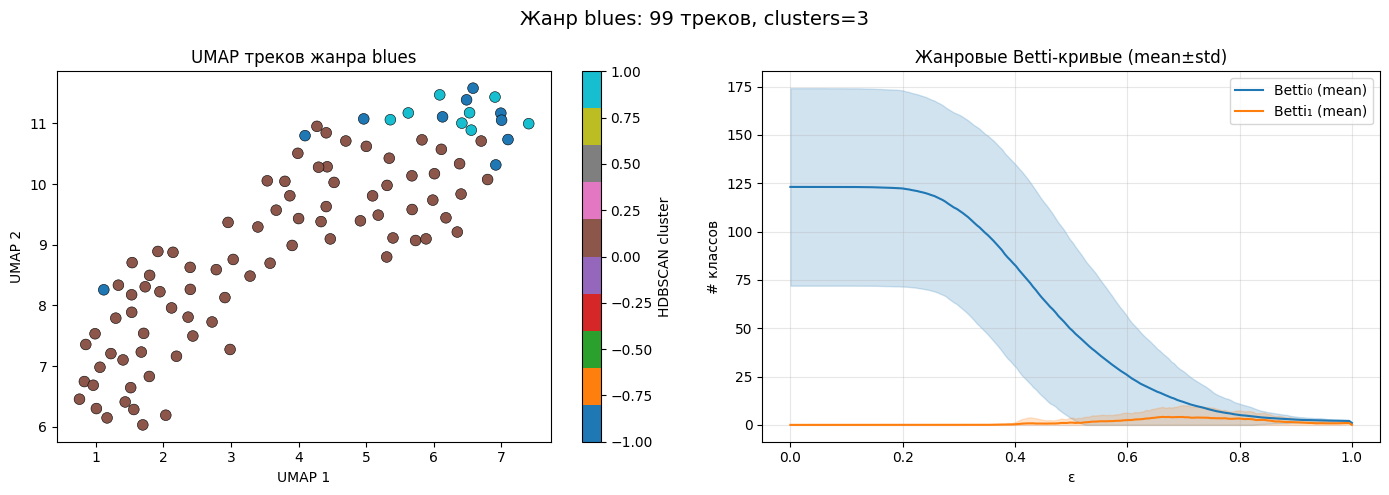

In [10]:
genre = "blues"
genre_reports[genre] = process_genre(genre, limit_tracks=None)


#### Classical


/Users/mverzhbitskiy/Documents/GitHub/3rdCourseWork/venv/lib/python3.11/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


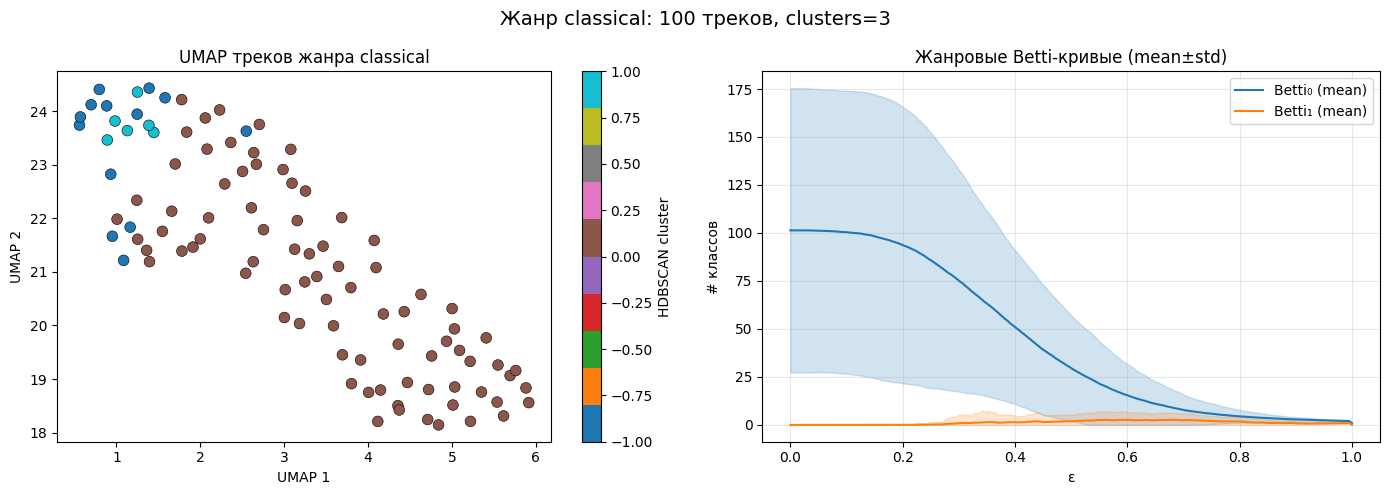

In [11]:
genre = "classical"
genre_reports[genre] = process_genre(genre, limit_tracks=None)


#### Country


/Users/mverzhbitskiy/Documents/GitHub/3rdCourseWork/venv/lib/python3.11/site-packages/ripser/ripser.py:251: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(


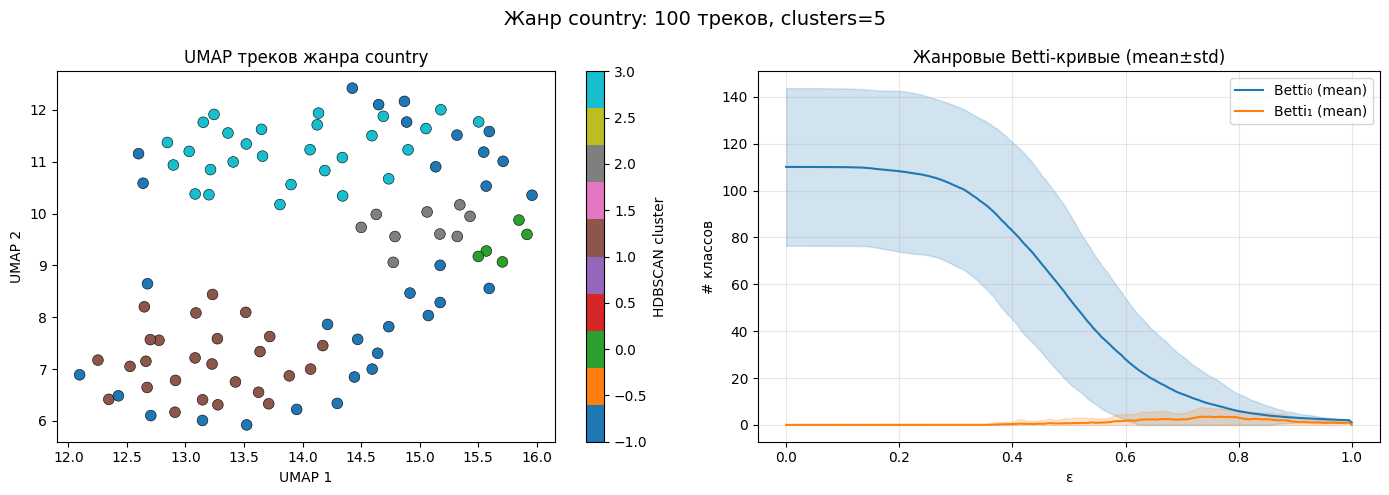

In [12]:
genre = "country"
genre_reports[genre] = process_genre(genre, limit_tracks=None)


#### Electronic


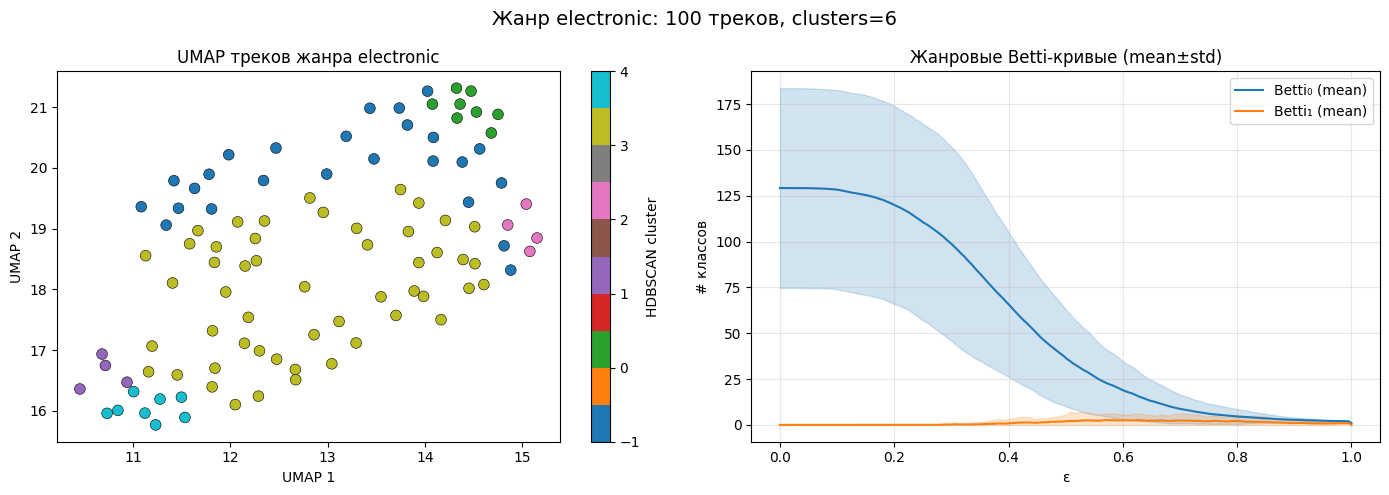

In [13]:
genre = "electronic"
genre_reports[genre] = process_genre(genre, limit_tracks=None)


#### Hip-hop


/Users/mverzhbitskiy/Documents/GitHub/3rdCourseWork/venv/lib/python3.11/site-packages/ripser/ripser.py:251: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(


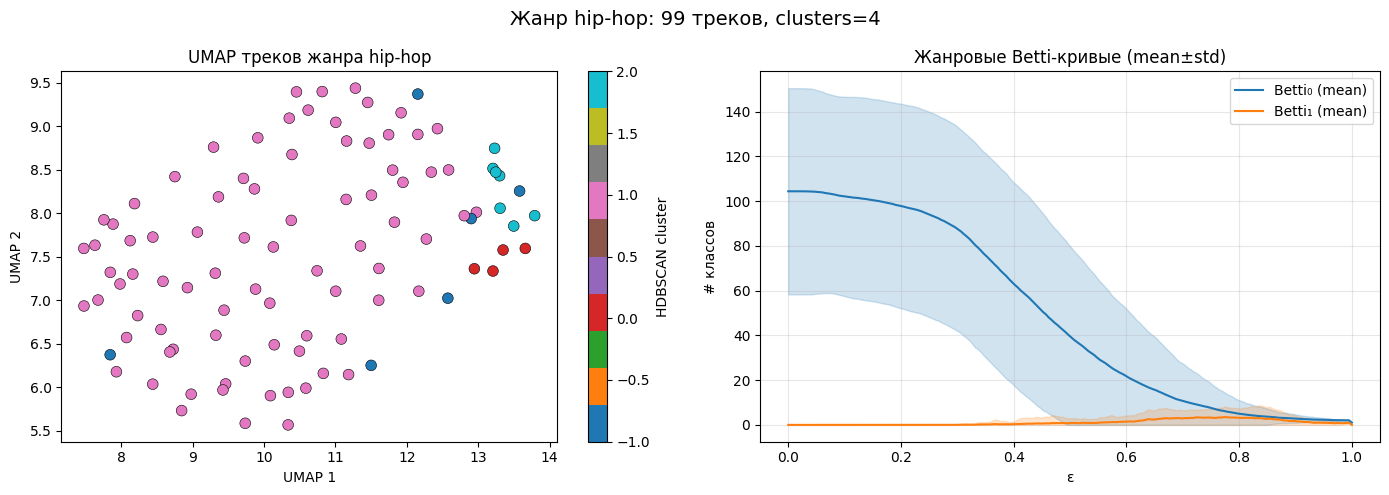

In [14]:
genre = "hip-hop"
genre_reports[genre] = process_genre(genre, limit_tracks=None)


#### Jazz


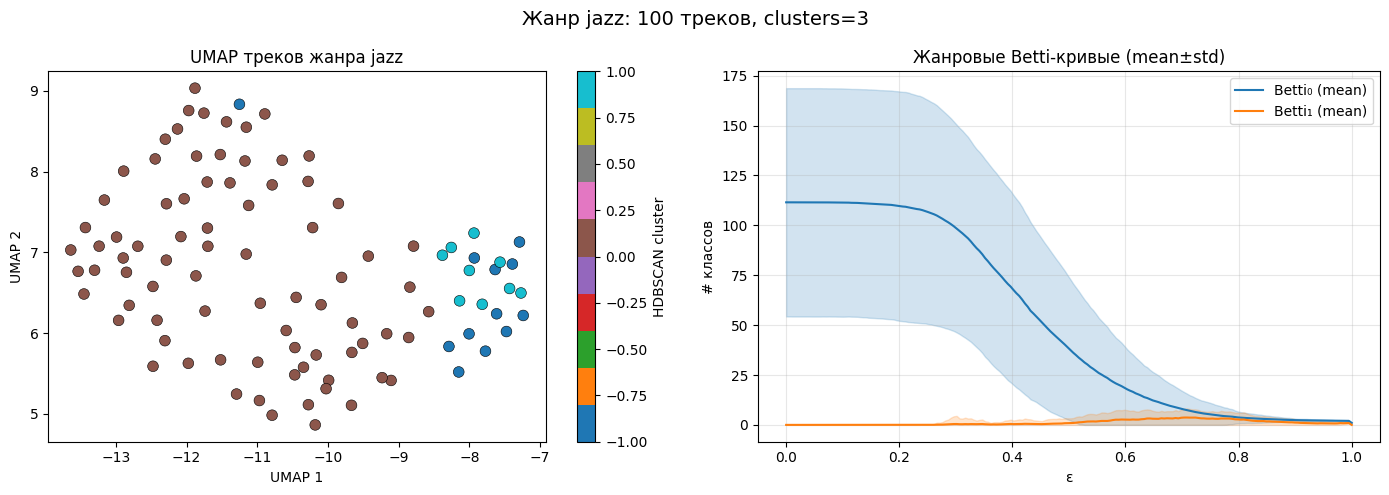

In [15]:
genre = "jazz"
genre_reports[genre] = process_genre(genre, limit_tracks=None)


#### Metal


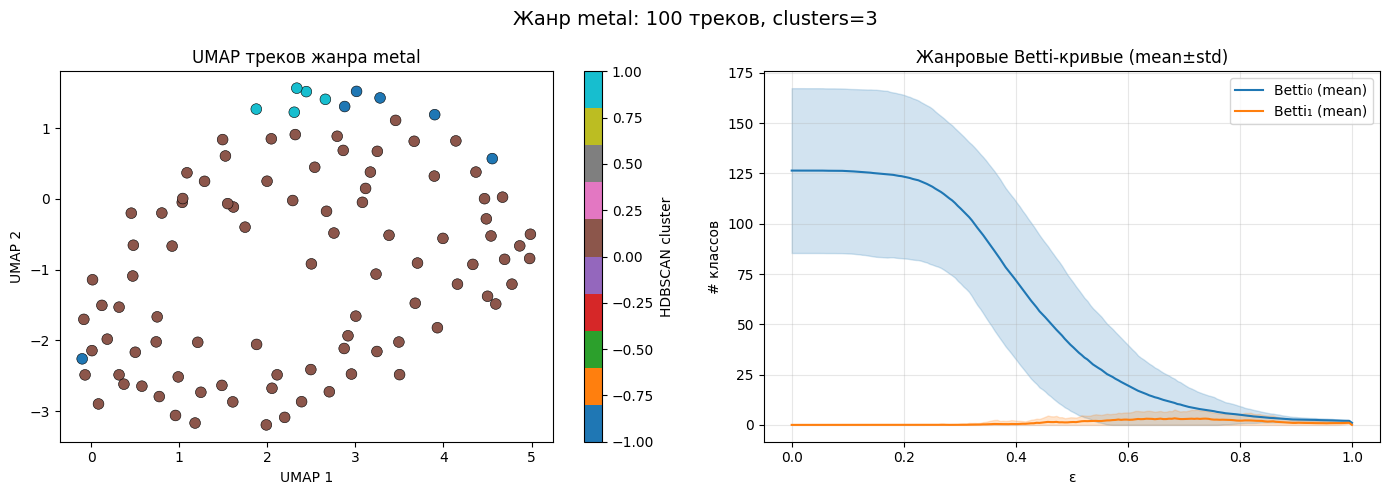

In [16]:
genre = "metal"
genre_reports[genre] = process_genre(genre, limit_tracks=None)


#### Pop


/Users/mverzhbitskiy/Documents/GitHub/3rdCourseWork/venv/lib/python3.11/site-packages/ripser/ripser.py:251: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
/Users/mverzhbitskiy/Documents/GitHub/3rdCourseWork/venv/lib/python3.11/site-packages/ripser/ripser.py:251: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(


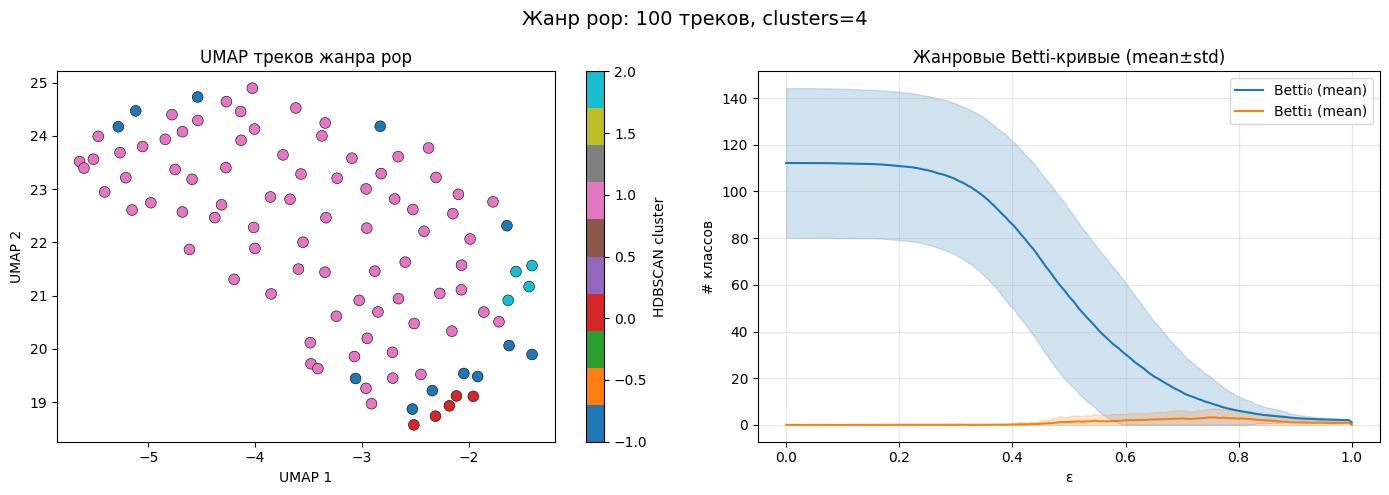

In [17]:
genre = "pop"
genre_reports[genre] = process_genre(genre, limit_tracks=None)


#### Reggae


/Users/mverzhbitskiy/Documents/GitHub/3rdCourseWork/venv/lib/python3.11/site-packages/ripser/ripser.py:251: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(


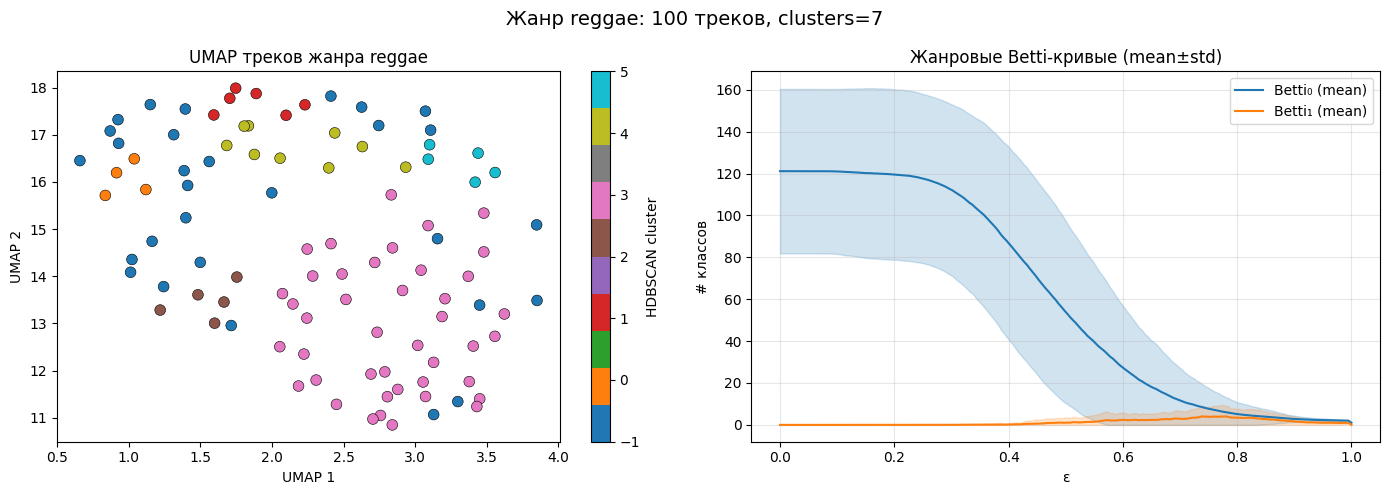

In [18]:
genre = "reggae"
genre_reports[genre] = process_genre(genre, limit_tracks=None)


#### Rock


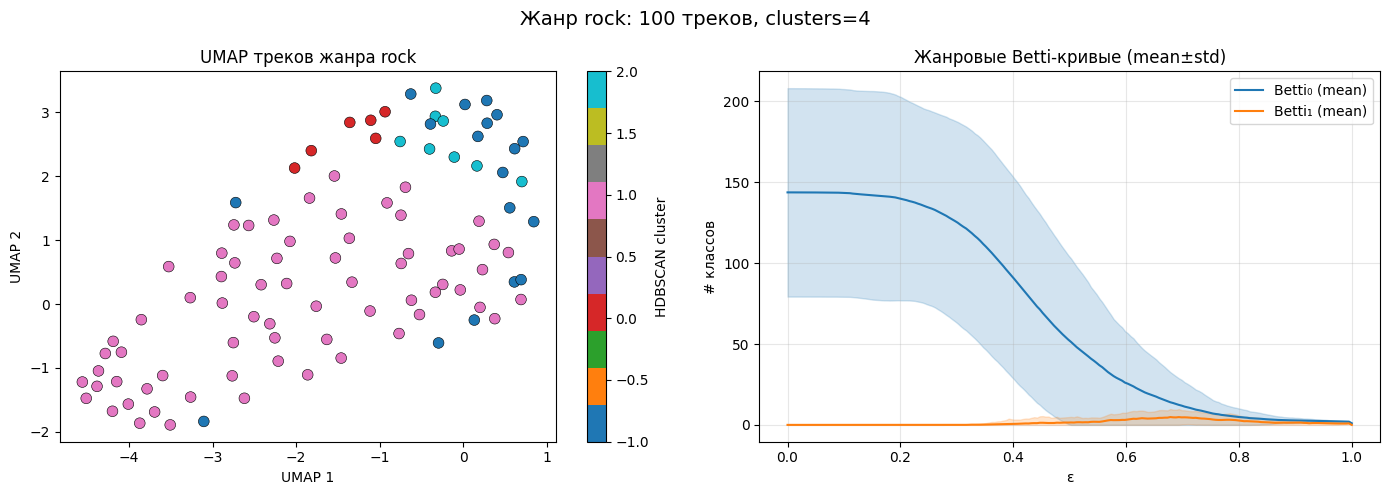

In [19]:
genre = "rock"
genre_reports[genre] = process_genre(genre, limit_tracks=None)
